In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack

C:\Users\ravur\AppData\Local\Temp\ipykernel_7220\253330227.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.columns, y=df.isnull().sum().values, palette='viridis')


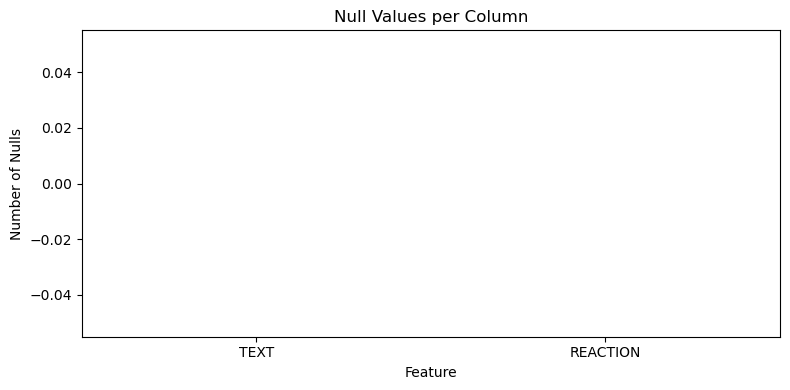

C:\Users\ravur\AppData\Local\Temp\ipykernel_7220\253330227.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='REACTION', palette='Set2')


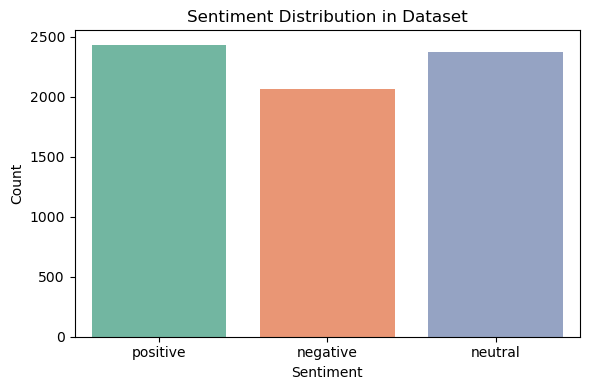

In [3]:
df = pd.read_csv("DATASET.csv")
df.dropna(subset=['TEXT', 'REACTION'], inplace=True)
plt.figure(figsize=(8,4))
sns.barplot(x=df.columns, y=df.isnull().sum().values, palette='viridis')
plt.title('Null Values per Column')
plt.ylabel('Number of Nulls')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()
print("\n")

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='REACTION', palette='Set2')
plt.title('Sentiment Distribution in Dataset')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.tight_layout()
plt.show()
print("\n")

In [4]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www.\S+", '', text)              # Remove URLs
    text = re.sub(r"[^\w\s.,!?;:]", '', text)                # Keep helpful punctuation
    text = re.sub(r"\s+", " ", text).strip()                 # Normalize whitespace
    return text

df['TEXT'] = df['TEXT'].apply(clean_text)

In [5]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['REACTION'])  # e.g., {'negative': 0, 'neutral': 1, 'positive': 2}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    df['TEXT'], df['label'], test_size=0.2,
    stratify=df['label'], random_state=42
)

In [16]:
word_vect = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    max_features=8000,
    stop_words='english',
    sublinear_tf=True
)

char_vect = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 5),
    max_features=7000,
    sublinear_tf=True
)

# Combine word + character features
vectorizer = FeatureUnion([("word", word_vect), ("char", char_vect)])
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [17]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_vec, y_train)

In [18]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_bal),
    y=y_train_bal
)
weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
sample_weights = np.array([weight_dict[y] for y in y_train_bal])

In [19]:
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.06,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method='hist',
    random_state=42
)

xgb.fit(X_train_bal, y_train_bal, sample_weight=sample_weights)
y_pred = xgb.predict(X_test_vec)

✅ Accuracy: 77.31%

              precision    recall  f1-score   support

    negative       0.78      0.72      0.75       414
     neutral       0.72      0.79      0.76       475
    positive       0.82      0.80      0.81       486

    accuracy                           0.77      1375
   macro avg       0.77      0.77      0.77      1375
weighted avg       0.78      0.77      0.77      1375



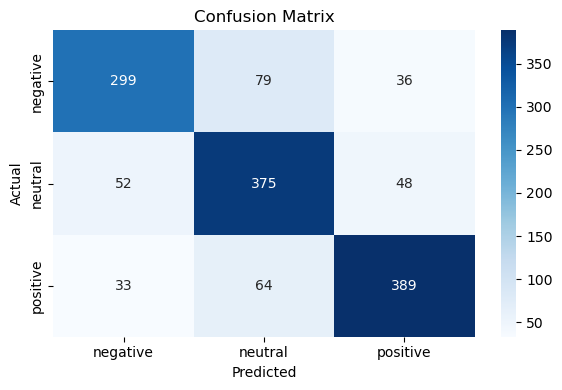

In [20]:
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {acc * 100:.2f}%\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
print("\n")

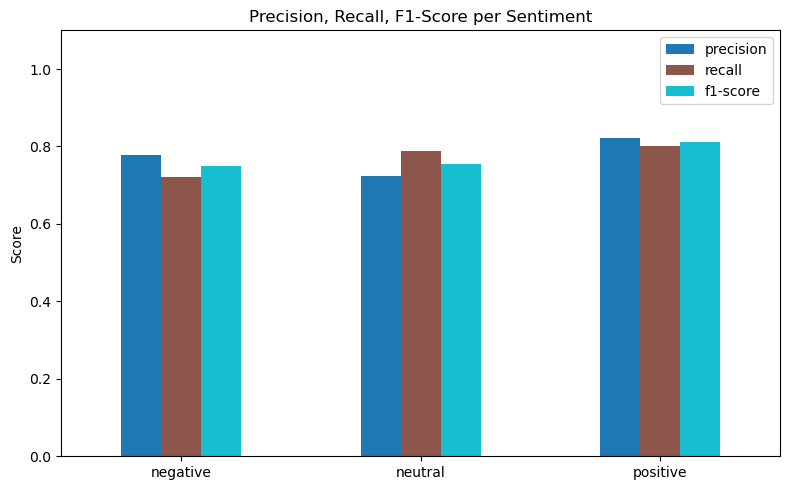

In [22]:
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
metrics_df = pd.DataFrame(report).T.iloc[:-3, :]  # Remove avg rows

metrics_to_plot = ['precision', 'recall', 'f1-score']
metrics_df[metrics_to_plot].plot(kind='bar', figsize=(8,5), colormap='tab10')
plt.title('Precision, Recall, F1-Score per Sentiment')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
joblib.dump(xgb, "xgboost_sentiment_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")

print("\n✅ Model, vectorizer, and label encoder saved!")


✅ Model, vectorizer, and label encoder saved!


In [24]:
import joblib
# Load the saved model, vectorizer, and label encoder
loaded_model = joblib.load('xgboost_sentiment_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')
loaded_label_encoder = joblib.load('label_encoder.pkl')

def predict_sentiment(text):
    # Clean the input text using the same function as in training
    cleaned_text = clean_text(text)

    # Vectorize the cleaned text
    text_vec = loaded_vectorizer.transform([cleaned_text])

    # Predict the label using the loaded model
    prediction = loaded_model.predict(text_vec)

    # Decode the predicted label back to the original sentiment string
    predicted_sentiment = loaded_label_encoder.inverse_transform(prediction)

    return predicted_sentiment[0]

# Example usage:
print("Type exit or quit to exit:")
while True:
  input_text = input()
  if(input_text != "exit" and input_text != "quit"):
    predicted = predict_sentiment(input_text)
    print(f"The sentiment of the text '{input_text}' is: {predicted}")
  elif (input_text == " "):
    print("Please enter a valid text")
  else:
    break

Type exit or quit to exit:


 i will end you


The sentiment of the text 'i will end you' is: neutral


 quit
